# Scoring model for LendingClub dataset - Technical notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

#created methods for datacleaning
# from loan_helper import data_cleaning
from loan_helper import data_converting
from loan_helper import column_description


In [2]:
!ls -lath LendingClub

total 1406288
drwxr-xr-x  13 Daniel  staff   416B Oct 22 17:45 ..
-rw-r--r--   1 Daniel  staff   6.0K Oct 22 17:37 .DS_Store
drwxr-xr-x   8 Daniel  staff   256B Oct 22 17:37 .
-rw-r--r--@  1 Daniel  staff    41M Oct 22 17:36 LoanStats3c_securev1.csv.zip
-rw-r--r--@  1 Daniel  staff    73M Oct 21 11:03 LoanStats3d_securev1.csv.zip
-rw-r--r--   1 Daniel  staff    23K Oct 21 11:03 LCDataDictionary.xlsx
-rwxr-xr-x@  1 Daniel  staff   357M Oct  1 06:44 LoanStats3d_securev1.csv
-rwxr-xr-x@  1 Daniel  staff   201M Oct  1 06:42 LoanStats3c_securev1.csv


## LendingClub data source:

https://www.lendingclub.com/info/download-data.action

In [3]:
description = pd.read_excel('LendingClub/LCDataDictionary.xlsx')

In [4]:
# from zipfile import ZipFile
# zip_file = ZipFile('LendingClub/LoanStats3d_securev1.csv.zip')
# data_lc = pd.read_csv(zip_file.open('LoanStats3d_securev1.csv'), low_memory=False, header=1)

In [5]:
#read LendingClub loan data from 2014
data_lc = pd.read_csv('LendingClub/LoanStats3c_securev1.csv', low_memory=False, header=1)

In [6]:
data_lc.head(2)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,36805548,NaN,10400.0,10400.0,10400.0,36 months,6.99%,321.08,A,A3,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN
1,38098114,NaN,15000.0,15000.0,15000.0,60 months,12.39%,336.64,C,C1,...,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
data_lc.loan_amnt.isna().sum()

2

In [8]:
#* * * IMPORTANT * * *
#removed two rows with full NAN values
data_lc = data_lc.loc[data_lc.loan_amnt.notnull()]
data_lc.shape

(235629, 150)

## Feature selection and feature engineering

### Understanding the columns

In order to understand the columns we created a dataframe with column names, two examples, datatype, number of missing values, and the long description. The dataframe was exported to excel to make decision on columns. The result is stored in col_selection.xlsx.

In [9]:
desc = column_description(data_lc, description)

In [10]:
pd.set_option('display.max_colwidth', -1) #this allows us to see the very long description, if exceeds 50 char
desc.head(5)

,col_name,exmp1,exmp2,dtype,Description,nan_counts
0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0
1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629
2,loan_amnt,7650,23325,float64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0
3,funded_amnt,7650,23325,float64,The total amount committed to that loan at that point in time.,0
4,funded_amnt_inv,7650,23325,float64,The total amount committed by investors for that loan at that point in time.,0


In [11]:
desc.to_excel('col_desc_2014.xlsx')

### First round feauture selection

Originally the dataset contained 150 columns. When we were reducing the features in order to avoid the overfitting the model we selected features according to the following:

- Discarded columns that contained payment or collection information (47 columns)
- Discarded columns that contained information that were not available at the time of credit application
- Discarded features that require too much data processing (typically free input i.e. emp_title)
- Discarded redundant features (subgrade - grade, title - purpose)
- Discarded feauters that contain too much NAN values (mnths_since_last_delinq, mths_since_recent_bc_dlq, mths_since_recent_revol_delinq)

In [12]:
col_selection = pd.read_excel('col_selection_2014.xlsx')

In [13]:
col_selection.head()

,Unnamed: 0,col_name,exmp1,exmp2,dtype,Description,nan_counts,Decision,Cause
0,0,id,37662224,36804663,object,A unique LC assigned ID for the loan listing.,0,remove,irrelevant
1,1,member_id,NaN,NaN,float64,A unique LC assigned Id for the borrower member.,235629,remove,irrelevant
2,2,loan_amnt,7650,23325,float64,"The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.",0,keep,NaN
3,3,funded_amnt,7650,23325,float64,The total amount committed to that loan at that point in time.,0,remove,redundant
4,4,funded_amnt_inv,7650,23325,float64,The total amount committed by investors for that loan at that point in time.,0,remove,redundant


In [14]:
selected_col = col_selection.loc[col_selection.Decision == 'keep', 'col_name'].to_list()
len(selected_col)

59

In [15]:
dataset = data_lc.loc[:, selected_col]

In [16]:
dataset.shape

(235629, 59)

In [ ]:
# dataset.info()

### Converting the data types

- emp_length column to convert numeric and missing values replaced with average
- earliest credit line: convert date to numeric (years)
- revol_util (revolving utilization) convert to numeric
- creating regions from state
- reduce categories of loan purpose

In [17]:
dataset = data_converting(dataset)

In [18]:
regions = {'W':  ['CA', 'OR', 'UT','WA', 'CO', 'NV', 'AK', 'MT', 'HI', 'WY', 'ID'], 
           'SW': ['AZ', 'TX', 'NM', 'OK'],
           'SE': ['GA', 'NC', 'VA', 'FL', 'KY', 'SC', 'LA', 'AL', 'WV', 'DC', 'AR', 'DE', 'MS', 'TN' ],
           'MW': ['IL', 'MO', 'MN', 'OH', 'WI', 'KS', 'MI', 'SD', 'IA', 'NE', 'IN', 'ND'],
           'NE': ['CT', 'NY', 'PA', 'NJ', 'RI','MA', 'MD', 'VT', 'NH', 'ME']}

In [19]:
for region, states in regions.items():
    for state in states:
        dataset.loc[dataset.addr_state == state, 'region'] = region
dataset.drop(columns = ['addr_state'], inplace=True)

AttributeError: 'DataFrame' object has no attribute 'addr_state'

In [ ]:
dataset.info()

### Deciding on the target feature

In [20]:
dataset.loan_status.value_counts()

Fully Paid            189555
Charged Off           41609 
Current               4215  
Late (31-120 days)    144   
In Grace Period       76    
Late (16-30 days)     30    
Name: loan_status, dtype: int64

#### Meaning of the categories
<b>Fully paid:</b> Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.

<b>Current:</b> Loan is up to date on all outstanding payments. 

<b>In Grace Period:</b> Loan is past due but within the 15-day grace period. 

<b>Late (16-30):</b> Loan has not been current for 16 to 30 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

<b>Late (31-120):</b> Loan has not been current for 31 to 120 days. Learn more about the tools LendingClub has to deal with delinquent borrowers.

<b>Default:</b> Loan has not been current for an extended period of time. Learn more about the difference between “default” and “charge off”.

<b>Charged Off:</b> Loan for which there is no longer a reasonable expectation of further payments. Upon Charge Off, the remaining principal balance of the Note is deducted from the account balance. Learn more about the difference between “default” and “charge off”.

Sosurce: https://help.lendingclub.com/hc/en-us/articles/215488038-What-do-the-different-Note-statuses-mean-

In [21]:
pd.crosstab(columns=dataset['loan_status'], index=dataset['term'],)

loan_status,Charged Off,Current,Fully Paid,In Grace Period,Late (16-30 days),Late (31-120 days)
term,,,,,,
36 months,22315,0,140255,0,0,0
60 months,19294,4215,49300,76,30,144


We decided to ignore the 'gray' categories, where there might chance to the recovery of the loan. The 'Current' category contains the 60 months term loans, removing them would panalize the long term loans by increasing the default rate within this category. 

In [22]:
#Select default categories:
dataset.loc[dataset.loan_status == 'Fully Paid', 'default'] = 0
dataset.loc[dataset.loan_status == 'Charged Off', 'default'] = 1
dataset.loc[dataset.loan_status == 'Current', 'default'] = 0

dataset = dataset.loc[dataset.default.notnull()]

In [23]:
#remove loan_status, default replace it
dataset = dataset.drop(columns='loan_status')

In [24]:
dataset = dataset.reset_index()
dataset = dataset.drop(columns='index')

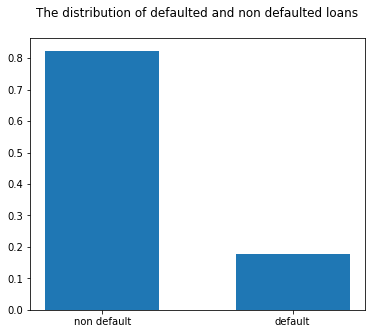

In [25]:
plt.figure(figsize=(6,5))
plt.bar(x=['non default', 'default'], height=dataset.default.value_counts()/len(dataset), width=0.6,)
plt.title('The distribution of defaulted and non defaulted loans\n')
ax=plt.gca();

In [26]:
# dataset.head()

In [27]:
x_feats = dataset.columns.to_list()
x_feats.remove('default')

### Multicollinearity examination

In [ ]:
# x_feats_cont =  x_feats
# x_feats_cont.remove('term')
# x_feats_cont.remove('home_ownership')
# x_feats_cont.remove('verification_status')
# x_feats_cont.remove('purpose')
# x_feats_cont.remove('region')

In [ ]:
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# X = dataset[x_feats_cont]
# imp_vif = SimpleImputer(strategy='median', copy=True, fill_value=None)
# imp_vif.fit(X)  
# X = imp_vif.transform(X)

In [ ]:
# vif = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
# list(zip(x_feats_cont, vif))

In [ ]:
# x_feats = ['revol_util','revol_bal','fico_range_low','grade','installment','loan_amnt','emp_length','annual_inc','delinq_2yrs','dti','delinq_2yrs','inq_last_6mths',
#            'pub_rec','collections_12_mths_ex_med', 'tot_coll_amt', 'total_rev_hi_lim','acc_open_past_24mths',
#            'avg_cur_bal','chargeoff_within_12_mths','delinq_amnt', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
#           'mths_since_recent_bc', 'mths_since_recent_inq','num_accts_ever_120_pd','num_tl_120dpd_2m',
#           'num_tl_30dpd','num_tl_90g_dpd_24m', 'num_tl_op_past_12m','percent_bc_gt_75', 'pub_rec_bankruptcies',
#           'tax_liens']
# x_feats += ['term','home_ownership','verification_status','purpose','region']

In [ ]:
# x_feats

In [28]:
x_feats.remove('level_0')

ValueError: list.remove(x): x not in list

In [29]:
len(x_feats)

58

## Preparing dataset for modeling

In [30]:
X = pd.get_dummies(dataset[x_feats], drop_first=True)

In [31]:
y = dataset.default

In [32]:
y.value_counts()

0.0    193770
1.0    41609 
Name: default, dtype: int64

In [33]:
X.head()

,loan_amnt,installment,grade,emp_length,annual_inc,dti,delinq_2yrs,earliest_cr_line,fico_range_low,inq_last_6mths,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_small_business,region_NE,region_SE,region_SW,region_W
0,10400.0,321.08,7,8.0,58000.0,14.92,0.0,26,710.0,2.0,...,0,0,0,0,0,0,0,0,0,1
1,15000.0,336.64,5,10.0,78000.0,12.03,0.0,21,750.0,0.0,...,0,0,0,0,0,0,0,1,0,0
2,9600.0,326.53,5,10.0,69000.0,25.81,0.0,23,680.0,0.0,...,0,0,0,0,0,0,1,0,0,0
3,12800.0,319.08,4,10.0,125000.0,8.31,1.0,15,665.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,21425.0,516.36,4,6.0,63800.0,18.49,0.0,12,685.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
X.shape

(235379, 72)

In [35]:
X.columns

Index(['loan_amnt', 'installment', 'grade', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'collections_12_mths_ex_med', 'tot_coll_amt', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 't

### Train-Test Split

In [36]:
#'Stratify=y' provide us the same ratio in the target variable then it was in the original dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y) #25%

In [37]:
y_train.mean()

0.1767761451051922

In [38]:
y_test.mean()

0.17676947914011387

### Further datacleaning separately for train and test



- annual_inc: in case of annual income we had to handle extreme values (there are many strategies, we were choosing truncating the extreme values to the value of the 99 quantile)
- imputing mean values in place of missing values


In [39]:
imp = SimpleImputer(strategy='median', copy=True, fill_value=None)
imp.fit(X_train)  

X_train_imp = imp.transform(X_train)      
X_test_imp = imp.transform(X_test)

In [40]:
income_trunc = X_train.annual_inc.quantile(q=0.99)
income_trunc

250000.0

In [41]:
b_train = X_train_imp > income_trunc
b_test = X_test_imp > income_trunc

In [42]:
X_train_imp[b_train] = income_trunc
X_test_imp[b_test] = income_trunc

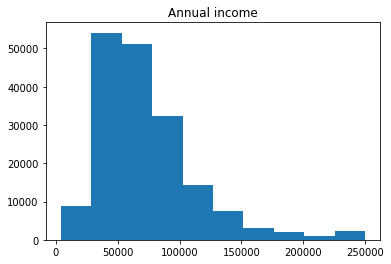

In [43]:
plt.hist(X_train_imp[:,4])
plt.title('Annual income');

In [44]:
# X_train = data_cleaning(X_train)

In [45]:
# X_test = data_cleaning(X_test)

- Setting Null values as mean for emp_lenth for both test and train

In [ ]:
# X_test.loc[X_test.emp_length.isna(), 'emp_length'] = round(X_test.emp_length.mean())

In [ ]:
# X_train.loc[X_train.emp_length.isna(), 'emp_length'] = round(X_train.emp_length.mean())

- Setting Null values as median for revol_util & dti for both test and train 

In [ ]:
# X_test.loc[X_test.revol_util.isna(), 'revol_util'] = X_test.revol_util.median(skipna=True)

In [ ]:
# X_train.loc[X_train.revol_util.isna(), 'revol_util'] = X_train.revol_util.median(skipna=True)

In [ ]:
# X_train.loc[X_train.dti.isna(), 'dti'] = X_train.dti.median(skipna=True)

In [ ]:
# X_test.loc[X_test.dti.isna(), 'dti'] = X_test.dti.median(skipna=True)

- Truncking income salary for both test and train

In [ ]:
# inc_trunc = X_test.annual_inc.quantile(q=0.995)
# X_test.loc[X_test.annual_inc>inc_trunc, 'annual_inc'] = X_test.annual_inc.quantile(q=0.995)

In [ ]:
# inc_trunc = X_train.annual_inc.quantile(q=0.995)
# X_train.loc[X_train.annual_inc>inc_trunc, 'annual_inc'] = X_train.annual_inc.quantile(q=0.995)

### Scaling

In [ ]:
# X_train_norm = scale(X_train, axis = 0) 
# X_test_norm = scale(X_test, axis = 0)

The following scaling method assures that the variables of X_train are within a 0-1 range

In [ ]:
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

#### Scaling using StandarScaler

- For SMOTE

In [47]:
scaler = StandardScaler()
scaler.fit(X_train_imp)
X_train_scaled = scaler.transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)

The following scaling method robost to outliers

In [ ]:
# scaler = RobustScaler()
# scaler.fit(X_train_imp)
# X_train_scaled = scaler.transform(X_train_imp)
# X_test_scaled = scaler.transform(X_test_imp)

# Objective: Increase predictibility of loan defaults from actual default 

#### Maximize the F1 score

In [48]:
def get_metric(y_train, y_probability):
    '''
    inputs: y_train values and from the trained model the y probabilities for default
    output: maximized F1 score, cut-off and the corresponding y_hat
    '''
    y = 0
    F1_score = 0
    cut_off = 0
    for cutoff in np.linspace(0,1,101):
        y_hat = (y_probability > cutoff) * 1
        f1 = f1_score(y_train, y_hat)
        if f1> F1_score:
            F1_score = f1
            cut_off = cutoff
            y = y_hat
    
    print('Recall:', recall_score(y_train, y))
    print('Precision:', precision_score(y_train, y))
    print('F1_score:', F1_score)
    print('Cut_off:', cut_off)
    
    conf_matrix = pd.DataFrame(confusion_matrix(y_train, y),
                                    index=['actual 0', 'actual 1'],
                                    columns=['predicted 0', 'predicted 1'])
    return conf_matrix

 ## Model Selection - Logistic regression

### Baseline: vanilla logistic regression w/o imbalance strategy

In [49]:
# Vanilla regression
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_scaled, y_train)

In [50]:
y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]

In [51]:
get_metric(y_train, y_probability)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6004742525715384
Precision: 0.29238570759868937
F1_score: 0.3932757589430937
Cut_off: 0.19


,predicted 0,predicted 1
actual 0,99976,45351
actual 1,12468,18739


In [52]:
p, r, t = precision_recall_curve(y_train, model_vanilla.decision_function(X_train_scaled))

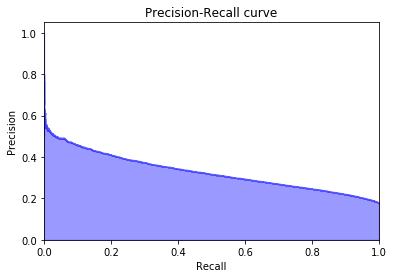

In [53]:
from inspect import signature
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(r, p, color='b', alpha=0.4, where='post')
plt.fill_between(r, p, color='b', alpha=0.4, **step_kwargs)
plt.xlabel('precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1])
plt.title('Precision-Recall curve');

In [ ]:
#SMOTE
#Logistic regression inbuilt class weight
#sklearn.
#imblearn.over_sampling.SMOTE
#RandomOverSampler
#Undersampling?
#C values influence to precision
#Different stragegy on precision


### Lasso regression with different C values (w/o imbalance strategy)

In [54]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l1 = LogisticRegression(C=C, penalty='l1',
                                   solver='liblinear',
                                   max_iter=200)
    print('-'*40,f'\nLasso regression with C = {C}')
    model_l1 = logreg_l1.fit(X_train_scaled, y_train)
    y_probability = model_l1.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)


---------------------------------------- 
Lasso regression with C = 0.01


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6024609863171724
Precision: 0.29095608034912873
F1_score: 0.3924028176363162
Cut_off: 0.19
---------------------------------------- 
Lasso regression with C = 0.1


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6014355753516839
Precision: 0.2925388487975187
F1_score: 0.3936203678459828
Cut_off: 0.19
---------------------------------------- 
Lasso regression with C = 1


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6007306053129106
Precision: 0.29244664919505803
F1_score: 0.3933858631217803
Cut_off: 0.19
---------------------------------------- 
Lasso regression with C = 10


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6005703848495529
Precision: 0.2924233913748986
F1_score: 0.3933304651675254
Cut_off: 0.19
---------------------------------------- 
Lasso regression with C = 100


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6006024289422245
Precision: 0.292429868630449
F1_score: 0.3933431968185014
Cut_off: 0.19
---------------------------------------- 
Lasso regression with C = 1000


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6005703848495529
Precision: 0.2924097043451127
F1_score: 0.39331808356592723
Cut_off: 0.19
---------------------------------------- 
Lasso regression with C = 10000


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6005383407568815
Precision: 0.2923941025040955
F1_score: 0.3932970976474785
Cut_off: 0.19


In [ ]:

# np.set_printoptions(formatter = {'float': '{:.5f}'.format})
# model_l1.coef_

#### Lasso regression with C=100

In [ ]:
# logreg_l1 = LogisticRegression(C=1, penalty='l1', solver='liblinear', max_iter=200)
# model_l1 = logreg_l1.fit(X_train_scaled, y_train)

In [ ]:
# coef_df = pd.DataFrame([X.columns, model_l1.coef_.tolist()[0]]).T

In [ ]:
# coef_df.columns = ['col_name', 'coef']

In [ ]:
# coef_df['abs'] = coef_df.coef.abs()

In [ ]:
# coef_df.loc[coef_df['abs']>0.1]

### Ridge regression with different C values (w/o imbalance strategy)

In [ ]:
C_values = [0.01, 0.1, 1, 10, 100, 1000, 10000]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l2 = LogisticRegression(C=C, penalty='l2',
                                   solver='newton-cg',
                                   max_iter=200)
    
    print('-'*40,f'\nRidge regression with C = {C}')
    model_l2 = logreg_l2.fit(X_train_scaled, y_train)
    y_probability = model_l2.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)

### Cross-Validation (w/o imbalance strategy)

In [ ]:
cv = StratifiedKFold(n_splits= 5, random_state=1000, shuffle=True)


#### Vanilla

In [ ]:
lr_vanilla = LogisticRegression(C=1e9,
                                solver='newton-cg',
                                max_iter=200)


cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_scaled, y=y_train,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)

In [ ]:
y_probability = cross_val_predict(lr_vanilla, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Ridge

In [ ]:
l2_reg = LogisticRegression(C=1,
                            solver='newton-cg',
                            penalty='l2',
                            max_iter=200)

cv_l2 = cross_validate(estimator=l2_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l2_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

#### Lasso

In [ ]:
l1_reg = LogisticRegression(C=1,
                            solver='saga',
                            penalty='l1',
                            max_iter=200)
cv_l1 = cross_validate(estimator=l1_reg, X=X_train_scaled, y=y_train,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [ ]:
y_probability = cross_val_predict(l1_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

## IMBALANCE STRATEGY: RANDOM OVERSAMPLING

## IMBALANCE STRATEGY: SMOTE

In [56]:
from imblearn.over_sampling import SMOTE

In [59]:
print(y.value_counts()) #Previous original class distribution
smote = SMOTE()
X_train_smote, y_train_smote = smote.fit_sample(X_train_scaled, y_train) 
print(pd.Series(y_train_smote).value_counts()) #Preview synthetic sample class distributi

0.0    193770
1.0    41609 
Name: default, dtype: int64
1.0    145327
0.0    145327
dtype: int64


### Baseline Vanilla

In [64]:
# Vanilla regression
logreg_vanilla = LogisticRegression(C=1e9, solver='liblinear', max_iter=200)

model_vanilla = logreg_vanilla.fit(X_train_smote, y_train_smote)

In [65]:
y_probability = model_vanilla.predict_proba(X_train_scaled)[:,1]

get_metric(y_train, y_probability)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.6010510462396257
Precision: 0.28848046754844664
F1_score: 0.38984900287860996
Cut_off: 0.52


,predicted 0,predicted 1
actual 0,99064,46263
actual 1,12450,18757


### Lasso regression with different C values

In [63]:
C_values = [0.01]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l1 = LogisticRegression(C=C, penalty='l1',
                                   solver='liblinear',
                                   max_iter=200)
    print('-'*40,f'\nLasso regression with C = {C}')
    model_l1 = logreg_l1.fit(X_train_smote, y_train_smote)
    y_probability = model_l1.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)


---------------------------------------- 
Lasso regression with C = 0.01


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.621623353734739
Precision: 0.28459721549814415
F1_score: 0.39043977055449336
Cut_off: 0.51


### Ridge regression with different C values 

In [66]:
C_values = [0.01]  # low value means high l1 penalty on coefficients

for C in C_values:
    logreg_l2 = LogisticRegression(C=C, penalty='l2',
                                   solver='newton-cg',
                                   max_iter=200)
    
    print('-'*40,f'\nRidge regression with C = {C}')
    model_l2 = logreg_l2.fit(X_train_smote, y_train_smote)
    y_probability = model_l2.predict_proba(X_train_scaled)[:,1]
    get_metric(y_train, y_probability)

---------------------------------------- 
Ridge regression with C = 0.01


//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.582561604768161
Precision: 0.2929848028234839
F1_score: 0.3898861223701988
Cut_off: 0.53


### Cross-Validation

In [68]:
cv = StratifiedKFold(n_splits= 5, random_state=1000, shuffle=True)


#### Vanilla

In [69]:
lr_vanilla = LogisticRegression(C=1e9,
                                solver='newton-cg',
                                max_iter=200)


cv_vanilla = cross_validate(estimator=lr_vanilla,
                            X=X_train_smote, y=y_train_smote,
                            cv=cv,
                            n_jobs=-1,
                            return_train_score=True)

In [70]:
y_probability = cross_val_predict(lr_vanilla, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.5992245329573493
Precision: 0.29179539993134224
F1_score: 0.39247373888953013
Cut_off: 0.19


,predicted 0,predicted 1
actual 0,99941,45386
actual 1,12507,18700


#### Ridge

In [71]:
l2_reg = LogisticRegression(C=1,
                            solver='newton-cg',
                            penalty='l2',
                            max_iter=200)

cv_l2 = cross_validate(estimator=l2_reg, X=X_train_smote, y=y_train_smote,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [72]:
y_probability = cross_val_predict(l2_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

//anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Recall: 0.5993527093280354
Precision: 0.2918077289108695
F1_score: 0.39251238143204903
Cut_off: 0.19


,predicted 0,predicted 1
actual 0,99934,45393
actual 1,12503,18704


#### Lasso

In [73]:
l1_reg = LogisticRegression(C=1,
                            solver='saga',
                            penalty='l1',
                            max_iter=200)
cv_l1 = cross_validate(estimator=l1_reg, X=X_train_smote, y=y_train_smote,
                       cv=cv,
                       n_jobs=-1,
                       return_estimator=True,
                       return_train_score=True)

In [74]:
y_probability = cross_val_predict(l1_reg, X_train_scaled, y_train, cv=cv, method='predict_proba')[:,1]
get_metric(y_train, y_probability)

//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:337: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the 

Recall: 0.5993527093280354
Precision: 0.29188969865322495
F1_score: 0.3925865289759251
Cut_off: 0.19


,predicted 0,predicted 1
actual 0,99952,45375
actual 1,12503,18704
